<a href="https://colab.research.google.com/github/RileyWClarke/BiancoGroup/blob/master/Notebooks/fftfilter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


#Potentially useful astropy stuff
import astropy
import astropy.io.ascii as ascii
from astropy.table import Table
from astropy.io import fits
from astropy.stats import LombScargle
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
from astropy.modeling import powerlaws
from astropy import constants as const
from astropy import units as u

#For reading in and organizing data
import pandas as pd
import requests
import json

#Misc
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from collections import Counter
import itertools
from sklearn.preprocessing import scale

#Making Figures look nice
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Collection

In [ ]:
k2targs = pd.read_csv('/content/gdrive/My Drive/hlsp_k2varcat_k2_lightcurve_c00-c04_kepler_v2_catalog.csv')
k2targs.head()

,# ID,Campaign,Class,Class Probs (DSCUT,EA,EB,GDOR,Noise,OTHPER,RRab),Anomaly Score
0,202059070,0,Noise,0.004195,0.120507,0.016615,0.005925,0.604636,0.246088,0.002034,0.023891
1,202059073,0,Noise,0.000000,0.000760,0.000037,0.000180,0.851359,0.147664,0.000000,0.003344
2,202059074,0,Noise,0.000086,0.003688,0.000218,0.007253,0.547118,0.441569,0.000067,0.083032
3,202059078,0,Noise,0.000523,0.002839,0.000332,0.000105,0.888648,0.107552,0.000000,0.000000
4,202059080,0,Noise,0.038219,0.082267,0.022758,0.058409,0.614507,0.078915,0.104926,0.136364


In [ ]:
targets = k2targs[['# ID', ' Campaign']].values
targets

array([[202059070,         0],
       [202059073,         0],
       [202059074,         0],
       ...,
       [211203438,         4],
       [211203556,         4],
       [211203589,         4]])

In [ ]:
toi_inds = [np.where(targets[:,0] == 211046195)[0][0],
        np.where(targets[:,0] == 210327027)[0][0],
        np.where(targets[:,0] == 211110493)[0][0]]

toi_inds

[66503, 53566, 68032]

In [ ]:
urls = ['https://archive.stsci.edu/missions/k2/lightcurves/c'
        +str(target[1])+'/'+str(target[0])[0:4]+'00000/'
        +str(target[0])[4:6]+'000/ktwo'+str(target[0])
        +'-c0'+str(target[1])+'_llc.fits' for target in targets]
urls[::5000]

['https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/59000/ktwo202059070-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c0/202000000/91000/ktwo202091770-c00_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201200000/35000/ktwo201235947-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201500000/09000/ktwo201509462-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201600000/98000/ktwo201698027-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c1/201800000/93000/ktwo201893576-c01_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/203500000/89000/ktwo203589087-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c2/204700000/54000/ktwo204754843-c02_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/205900000/32000/ktwo205932262-c03_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c3/206000000/89000/ktwo206089354-c03_llc.fits',


In [ ]:
toi_urls = [urls[toi] for toi in toi_inds]
toi_urls

['https://archive.stsci.edu/missions/k2/lightcurves/c4/211000000/46000/ktwo211046195-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/210300000/27000/ktwo210327027-c04_llc.fits',
 'https://archive.stsci.edu/missions/k2/lightcurves/c4/211100000/10000/ktwo211110493-c04_llc.fits']

In [ ]:
#Read in arrays via astropy.fits.open
def urls_to_dict(urls, campaign):
  d = {}
  for j, url in enumerate(urls):
    print()
    if url[51] == campaign:
      try:
        with fits.open(url, mode="readonly") as hdulist:
          d["k2bjds{0}".format(j)] = hdulist[1].data['TIME'] 
          d["pdcsap_flux{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX']
          d["pdcsap_flux_err{0}".format(j)] = hdulist[1].data['PDCSAP_FLUX_ERR']

      except: 
        print('Loop '+str(j)+' : File not found')

  return d

In [ ]:
d0 = urls_to_dict(urls[67000:68000], campaign='4')

In [ ]:
dtoi = urls_to_dict(toi_urls, campaign='4')

### Short Cadence Data

In [3]:
# read data

data1=np.loadtxt('/content/gdrive/My Drive/phot211046195r2_ssc.2m0335.dat')
data2=np.loadtxt('/content/gdrive/My Drive/phot210327027r2_ssc.2m0355.dat')

time1,flux1,xx1,yy1=data1[:,0],data1[:,1],data1[:,2],data1[:,3]
time2,flux2,xx1,yy2=data2[:,0],data2[:,1],data2[:,2],data2[:,3]

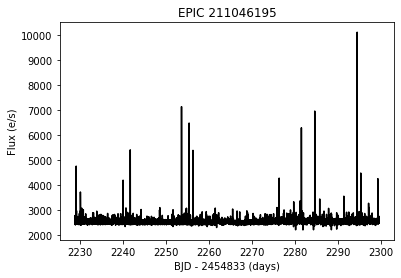

In [4]:
plt.plot(time1,flux1, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi1.png', dpi=100, bbox_inches='tight')

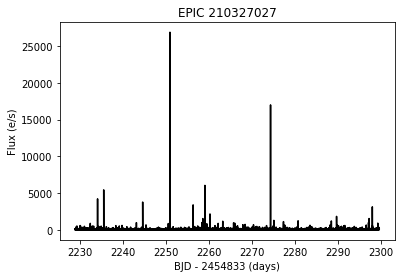

In [5]:
plt.plot(time2,flux2, c='k')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 210327027')
plt.savefig('toi2.png', dpi=100, bbox_inches='tight')

# Data Processing

In [ ]:
nanseries = []
for filename in d0:
  nanseries.append(d0[filename])

In [ ]:
np.save('gdrive/My Drive/nanseries', nanseries)

In [7]:
nanseries = np.load('gdrive/My Drive/nanseries.npy')

In [8]:
bjds = nanseries[::3]
fluxes = nanseries[1::3]
fluxerrs = nanseries[2::3]

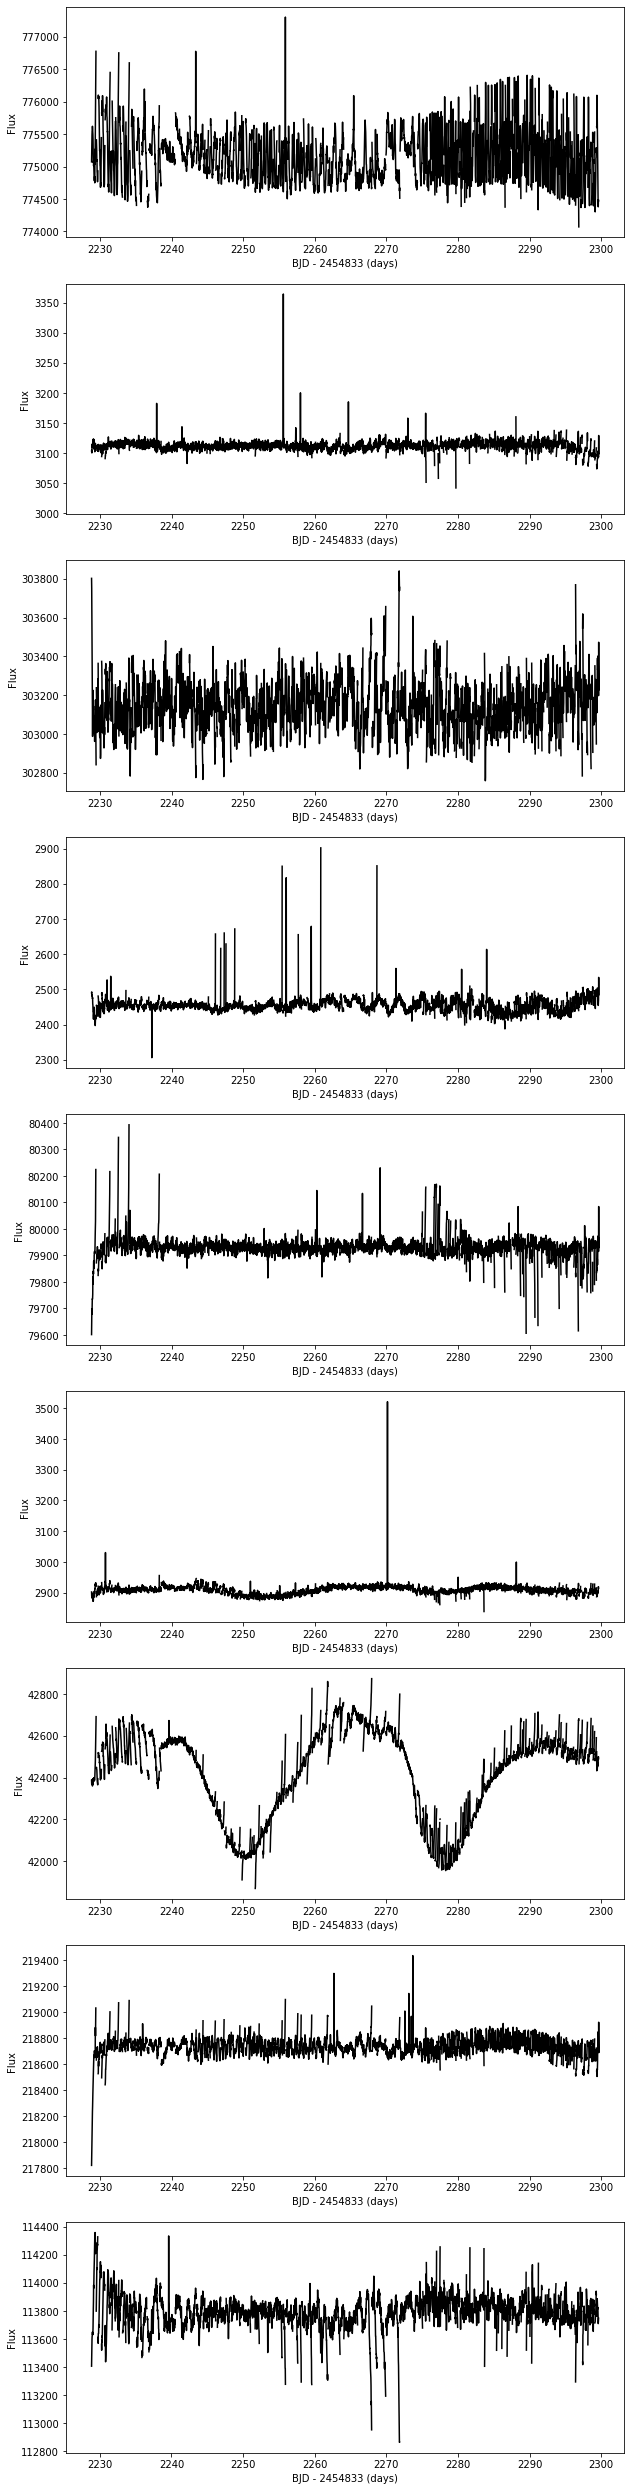

In [9]:
fig, axes = plt.subplots(9, figsize=(10,45))
p = 0
for i in range(0,900,100):
  #fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])
  axes[p].plot(bjds[i], fluxes[i], c='k')
  axes[p].set_ylabel('Flux')
  axes[p].set_xlabel('BJD - 2454833 (days)')
  p += 1
plt.savefig('gdrive/My Drive/nanseries.png', dpi=100)


## Truncation & Normalization

In [10]:
#Remove initial data gap
def trunc(bjds, fluxes, fluxerrs, start):
  l1 = []
  l2 = []
  l3 = []
  for i in range(len(bjds)):
    l1.append(bjds[i][start:])
    l2.append(fluxes[i][start:])
    l3.append(fluxerrs[i][start:])

  return l1, l2, l3

In [11]:
start = np.where(np.abs(fluxes[0]) >= 1)[0][0]
bjds, fluxes, fluxerrs = trunc(bjds, fluxes, fluxerrs, start)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


In [12]:
#Normalize flux values
for i in range(len(fluxes)):
  fluxes[i] = (fluxes[i] - np.nanmean(fluxes[i])) / np.nanstd(fluxes[i])

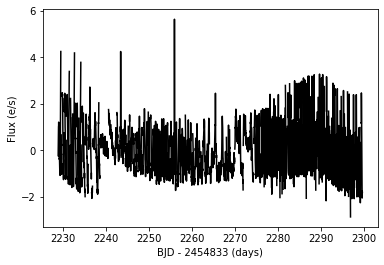

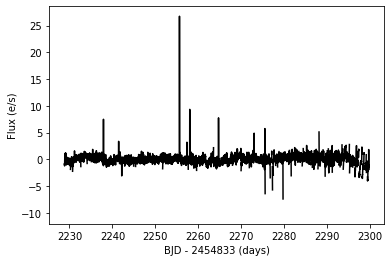

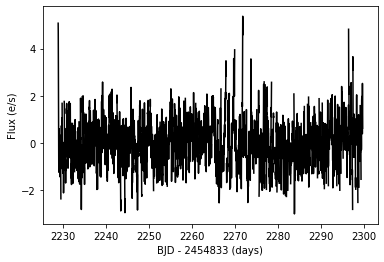

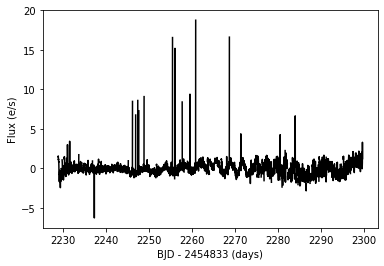

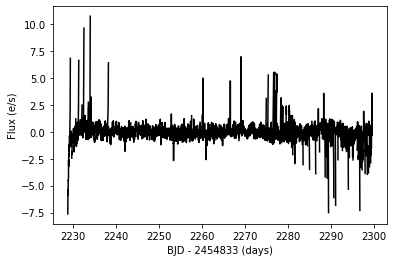

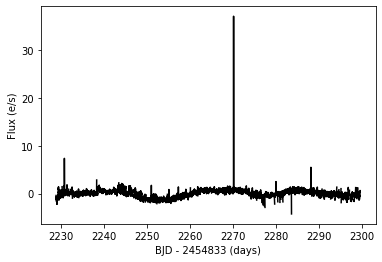

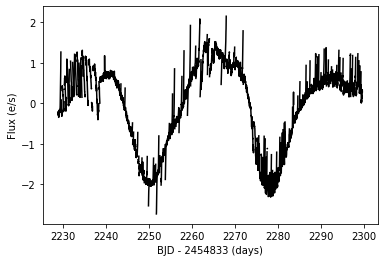

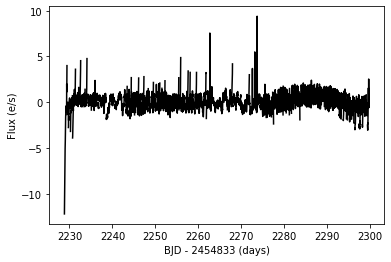

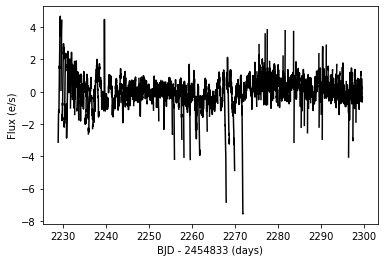

In [13]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

In [14]:
#Test for NaNs:
a = []
for j in range(len(bjds)):
  a.append(np.any(np.isnan(bjds[j]) == True))
  a.append(np.any(np.isnan(fluxes[j]) == True))
  a.append(np.any(np.isnan(fluxerrs[j]) == True))
np.any(a)#If NaNs exist, this returns True

True

In [15]:
'''
#Build list of # of consectutive nans + their indices in series
bjd_gaps = []
flux_gaps = []
fluxerr_gaps = []

for bjd in bjds:
  nancount = 0
  for i in range(len(bjd)):
    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == False):
      nancount += 1
      bjd_gaps.append(nancount)
      nancount = 0

    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == True):
      nancount += 1

for flux in fluxes:
  nancount = 0
  for i in range(len(flux)):

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == False):
      nancount += 1
      flux_gaps.append(nancount)
      nancount = 0

    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == True):
      nancount += 1

for fluxerr in fluxerrs:
  nancount = 0
  for i in range(len(fluxerr)):
    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == False):
      nancount += 1
      fluxerr_gaps.append(nancount)
      nancount = 0

    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == True):
      nancount += 1
'''

'\n#Build list of # of consectutive nans + their indices in series\nbjd_gaps = []\nflux_gaps = []\nfluxerr_gaps = []\n\nfor bjd in bjds:\n  nancount = 0\n  for i in range(len(bjd)):\n    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == False):\n      nancount += 1\n      bjd_gaps.append(nancount)\n      nancount = 0\n\n    if (np.isnan(bjd[i]) == True) and (np.isnan(bjd[i+1]) == True):\n      nancount += 1\n\nfor flux in fluxes:\n  nancount = 0\n  for i in range(len(flux)):\n\n    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == False):\n      nancount += 1\n      flux_gaps.append(nancount)\n      nancount = 0\n\n    if (np.isnan(flux[i]) == True) and (np.isnan(flux[i+1]) == True):\n      nancount += 1\n\nfor fluxerr in fluxerrs:\n  nancount = 0\n  for i in range(len(fluxerr)):\n    if (np.isnan(fluxerr[i]) == True) and (np.isnan(fluxerr[i+1]) == False):\n      nancount += 1\n      fluxerr_gaps.append(nancount)\n      nancount = 0\n\n    if (np.isnan(fluxerr[i]) == Tr

In [16]:
'''
plt.hist(flux_gaps)
plt.yscale('log')
plt.xlabel('Gap Width')
plt.title('Gap Width in Fluxes')
plt.savefig('nanhist', dpi=200)
'''

"\nplt.hist(flux_gaps)\nplt.yscale('log')\nplt.xlabel('Gap Width')\nplt.title('Gap Width in Fluxes')\nplt.savefig('nanhist', dpi=200)\n"

## Linear Interpolation

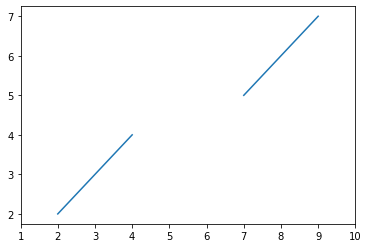

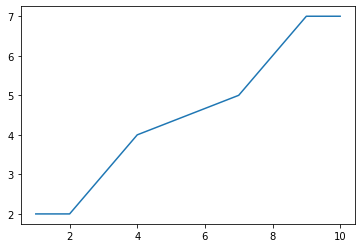

In [17]:
#Simple linear interpolation model:
x = [1,2,3,4,5,6,7,8,9,10]
y = [np.nan,2,3,4,np.nan,np.nan,5,6,7,np.nan]

plt.plot(x,y)
plt.xlim(1,10)
plt.show()

if np.isnan(y[0]) == True:
  for i,j in enumerate(y):
    if np.isnan(j) == False:
      y[:i] = np.full(i, j)
      break
    else:
      pass

if np.isnan(y[-1]) == True:
  for i,j in enumerate(y[::-1]):
    if np.isnan(j) == False:
      y[-i:] = np.full(i, j)
      break
    else:
      pass

bools = np.isnan(y)
edges = np.diff(bools)
edgeindx = np.where(~(edges == 0))[0]+1

for i, edge in enumerate(edgeindx):
  if i%2 == 0:

    a, b = np.polyfit((x[edge-1], x[edgeindx[i+1]]), (y[edge-1], y[edgeindx[i+1]]) , 1)
    ynew = a * np.array(x[edge:edgeindx[i+1]]) + b

  else:
    continue
  
  y[edge:edgeindx[i+1]] = ynew

plt.plot(x,y)

In [18]:
def lin_interp_nans(time, flux):
    newflux = np.copy(flux)

    #if series tip/tail is nan, replace with first/last real value:

    if np.isnan(newflux[0]) == True:
      for i,j in enumerate(newflux):
        if np.isnan(j) == False:
          newflux[:i] = np.full(i, j)
          break
        else:
          pass

    if np.isnan(newflux[-1]) == True:
      for i,j in enumerate(newflux[::-1]):
        if np.isnan(j) == False:
          newflux[-i:] = np.full(i, j)
          break
        else:
          pass

    #patching:
    bools = np.isnan(newflux)
    edges = np.diff(bools)
    edgeindx = np.where(~(edges == 0))[0]+1
    
    for i, edge in enumerate(edgeindx):
    
      if i%2 == 0:
      
        a, b = np.polyfit( (edge-1, edgeindx[i+1]),
                           (flux[edge-1], flux[edgeindx[i+1]]), deg = 1)
        
        patch = a * np.arange(edge,edgeindx[i+1]) + b 
        
      else:
        continue

      newflux[edge:edgeindx[i+1]] = patch
      
    return newflux

In [19]:
#Interpolate the flux arrays:
for i, flux in enumerate(fluxes):
  fluxes[i] = lin_interp_nans(bjds[i], flux)

In [20]:
#Test for NaNs:
a = []
for j in range(len(fluxes)):
  a.append(np.any(np.isnan(fluxes[j]) == True))
np.any(a)#If NaNs exist, this returns True

False

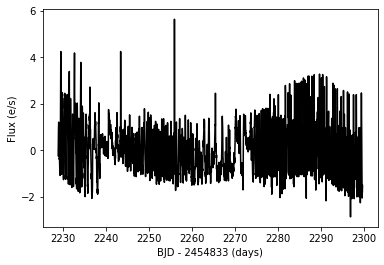

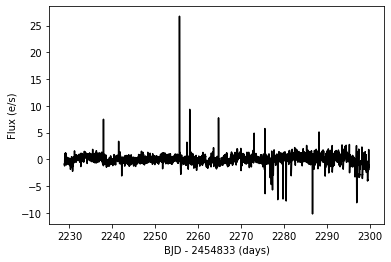

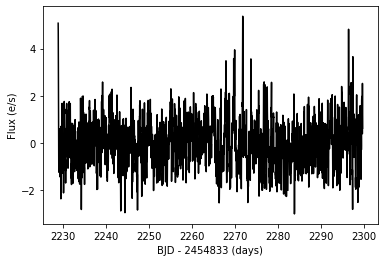

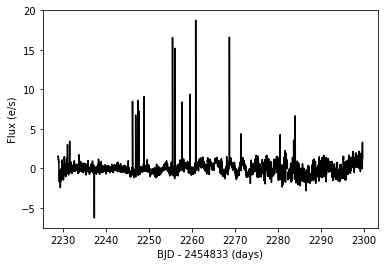

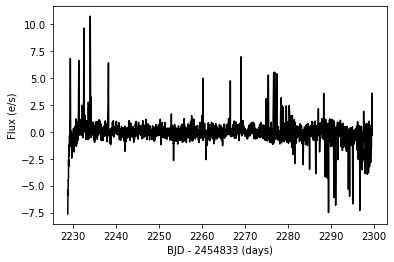

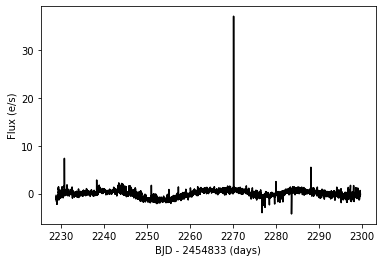

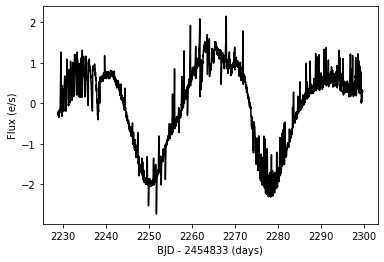

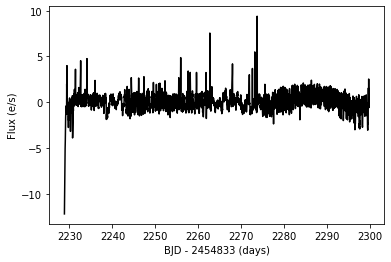

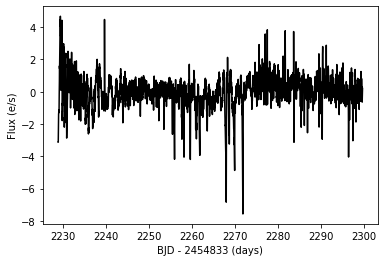

In [21]:
for i in range(0,900,100):
  plt.plot(bjds[i], fluxes[i], c='k')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Flux (e/s)')
  plt.show()

# FFT Filtering

In [22]:
def invgaussian(m, s, x):
    g = -np.exp(-(m-x)**2 / s**2) + 1 
    return g

In [23]:
def bandpass_ifft(t, flux, low_cutoff, high_cutoff, sample=1, 
                  M=None, inv_box=False, gf_sig = 1, Filter='box', Plot=''):
    """Bandpass filtering on a real signal using inverse FFT
    
    Inputs
    =======
    
    X: 1-D numpy array of floats, the real time domain signal (time series) to be filtered
    Low_cutoff: float, frequency components below this frequency will not pass the filter (physical frequency in unit of Hz)
    High_cutoff: float, frequency components above this frequency will not pass the filter (physical frequency in unit of Hz)
    sample: float, the sampling frequency of the signal (physical frequency in unit of Hz)    
    M: idk lmao
    inv_box: If using box filter, setting inv=True filters out frequencies outside the box
    Filter: Default filter is box, can choose 'Gaussian' also
    
    Notes
    =====
    1. The input signal must be real, not imaginary nor complex
    2. The Filtered_signal will have only half of original amplitude. Use abs() to restore. 
    3. In Numpy/Scipy, the frequencies goes from 0 to F_sample/2 and then from negative F_sample to 0. 
    
    """        
    #perform fft
    spectrum = np.fft.rfft(flux) 
    freq = np.fft.rfftfreq(len(flux), sample)
    freq_sort = np.sort(spectrum)
    
    #calculate the index of the cut off points
    lc = np.abs(freq) < Low_cutoff
    hc = np.abs(freq) > High_cutoff
    between = ~(lc + hc)
    
    ps = np.abs(spectrum)**2
    if ('PS' in Plot) or ('All' in Plot):
      plt.plot(freq, ps)
      plt.title("power spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Power Spectral Density')
      #plt.xlim(0,100)
      #plt.savefig('Figures/spec.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()

    if ('DFT' in Plot) or ('All' in Plot):
      plt.plot(freq, spectrum)
      #plt.plot(freq[between], spectrum[between], alpha=0.5)
      plt.title("real fourier transform ")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      #plt.xlim(0,100)
      #plt.savefig('Figures/fft.png', bbox_inches='tight', pad_inches=0.5)
      plt.show()
    
    
    
    if Filter == 'box':
    
      #filtered_spectrum = spectrum.copy()
    
      if inv_box == True:
        x_1 = np.arange(0, Low_cutoff, 0.1)
        x_2 = np.arange(High_cutoff, np.max(freq), 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_1, [plt.ylim()[0]] * len(x_1), 
                     [plt.ylim()[1]] * len(x_1), color='r', alpha=0.3)
        plt.fill_between(x_2, [plt.ylim()[0]] * len(x_2), 
                     [plt.ylim()[1]] * len(x_2), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[lc] = 0.
        filtered_spectrum[hc] = 0.
      else:
        x_ = np.arange(Low_cutoff, High_cutoff, 0.1)
        plt.plot(freq, spectrum)
        plt.fill_between(x_, [plt.ylim()[0]] * len(x_), 
                     [plt.ylim()[1]] * len(x_), color='r', alpha=0.3)
        plt.title("range to suppress")
        plt.figure()
        filtered_spectrum[between] = 0.
    
    if Filter == 'Gaussian':
      ig = invgaussian(np.median([low_cutoff,high_cutoff]), gf_sig, freq)
      filtered_spectrum = spectrum * ig
      if ('filter' in Plot) or ('All' in Plot):
        plt.plot(freq, ig)
        plt.title('Gaussian Filter')
        #plt.savefig('Figures/gfilter.png')
        #plt.xlim(0,100)
        plt.figure()

    if ('spec_filtered' in Plot) or ('All' in Plot):
      plt.plot(freq, filtered_spectrum, label="filtered spectrum")
      plt.plot(freq, spectrum, c='k', ls="--", label="spectrum", alpha=0.5)
      plt.title("Unfiltered vs. Filtered Spectrum")
      plt.xlabel('Frequency (1/day)')
      plt.ylabel('Amplitude')
      ldg = plt.legend(fontsize=12)
      #plt.xlim(0,100)
      #plt.savefig('Figures/filter_compare.png', bbox_inches='tight', pad_inches=0.5)
      plt.figure()

    filtered_signal = np.fft.irfft(filtered_spectrum)  # Construct filtered signal

    if ('signal_filtered' in Plot) or ('All' in Plot):
      fig = plt.figure(figsize=(15,10)) 
      plt.plot(t, filtered_signal, label="filtered signal")
      plt.plot(t, flux, c='k', ls="--", label="original signal", alpha=0.5)
      plt.xlabel('Time')
      plt.ylabel('Amplitude')
      plt.title("Unfiltered vs. Filtered Signal")
      #plt.savefig('Figures/filtered_signal.png', bbox_inches='tight', pad_inches=0.5)
      plt.legend()
      #Filtered_signal = np.zeros_like(Filtered_signal)
    return spectrum, freq, filtered_spectrum, filtered_signal, Low_cutoff, High_cutoff

In [24]:
dfts = []
pspectra = []
for i, flux in enumerate(fluxes):
  Low_cutoff, High_cutoff, F_sample = 4, 6, np.diff(bjds[i])[0]
  Spectrum, frequency, Filtered_spectrum, Filtered_signal, Low_freq, High_freq = bandpass_ifft(bjds[i], flux, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 1, Filter='Gaussian')

  dfts.append(Spectrum)
  pspectra.append(np.abs(Spectrum)**2)

## Short Cadence FFT Filtering

In [25]:
flux1norm = flux1 / sigma_clip(flux1, sigma=3).mean()

In [26]:
flux2norm = flux2 / sigma_clip(flux2, sigma=3).mean()

In [76]:
Low_cutoff, High_cutoff, F_sample = 3.9, 4, np.diff(time1)[0]
Spectrum1, frequency1, Filtered_spectrum1, Filtered_signal1, Low_freq, High_freq = bandpass_ifft(time1, flux1norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.25, Filter='Gaussian')

In [77]:
Low_cutoff, High_cutoff, F_sample = 3.9, 4, np.diff(time2)[0]
Spectrum2, frequency2, Filtered_spectrum2, Filtered_signal2, Low_freq, High_freq = bandpass_ifft(time2, flux2norm, Low_cutoff, High_cutoff, 
                          F_sample, gf_sig = 0.25, Filter='Gaussian')

In [ ]:
plt.plot(frequency1[1:],np.abs(Spectrum1[1:])**2)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend()
plt.xlim(0,10);

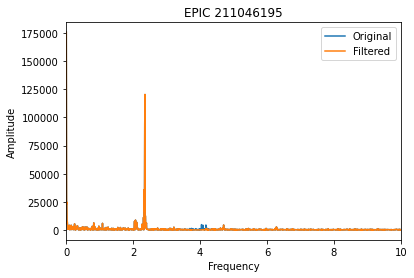

In [78]:
plt.plot(frequency1[1:],np.abs(Spectrum1[1:])**2, label='Original')
plt.plot(frequency1[1:],np.abs(Filtered_spectrum1[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend()
plt.xlim(0,10);

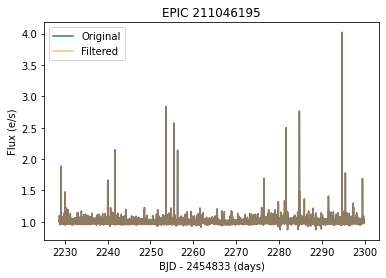

In [79]:
plt.plot(time1,flux1norm, label='Original')
plt.plot(time1,Filtered_signal1,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi1_filtered.png', dpi=100, bbox_inches='tight')
plt.legend();

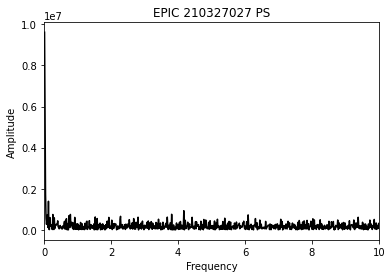

In [80]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 210327027 PS')
plt.xlim(0,10)
plt.savefig('toi2ps.png', dpi=100, bbox_inches='tight')

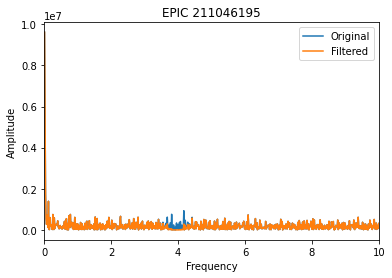

In [81]:
plt.plot(frequency2[1:],np.abs(Spectrum2[1:])**2, label='Original')
plt.plot(frequency2[1:],np.abs(Filtered_spectrum2[1:])**2, label='Filtered')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('EPIC 211046195')
plt.legend()
plt.xlim(0,10);

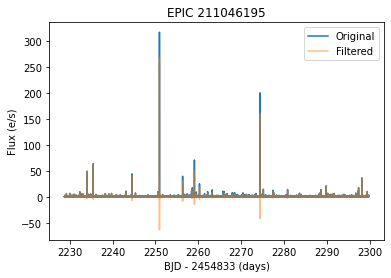

In [82]:
plt.plot(time2,flux2norm, label='Original')
plt.plot(time2[1:],Filtered_signal2,alpha=0.5, label='Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Flux (e/s)')
plt.title('EPIC 211046195')
plt.savefig('toi2_filtered.png', dpi=100, bbox_inches='tight')
plt.legend();

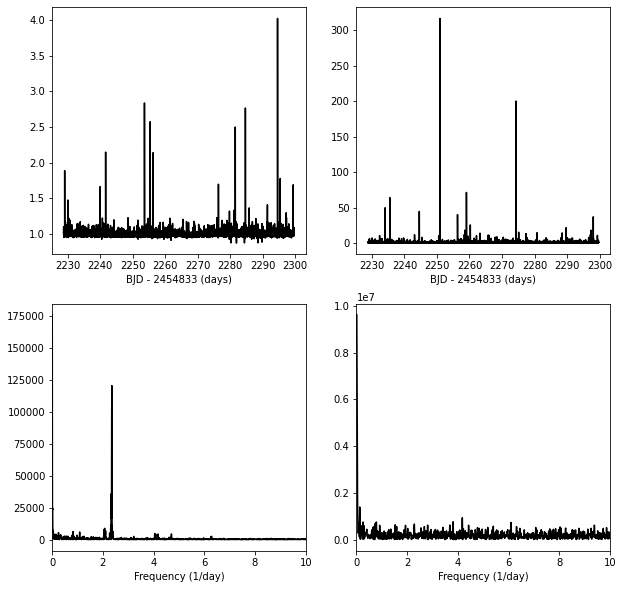

In [125]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(time1,flux1norm, c='k')
ax[0,1].plot(time2,flux2norm, c='k')
ax[1,0].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')
ax[1,1].plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')

ax[0,0].set_xlabel('BJD - 2454833 (days)')
ax[0,1].set_xlabel('BJD - 2454833 (days)')
ax[1,0].set_xlabel('Frequency (1/day)')
ax[1,1].set_xlabel('Frequency (1/day)')

ax[1,0].set_xlim(0,10)
ax[1,1].set_xlim(0,10)

plt.savefig('4plot.png', dpi=100, bbox_inches='tight')

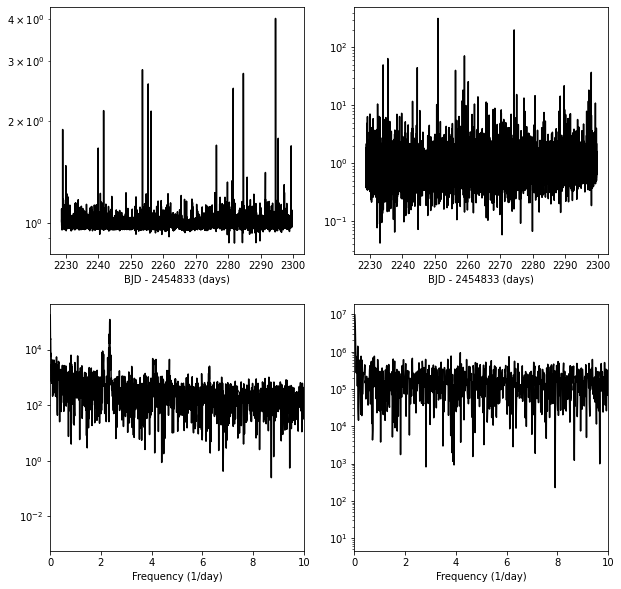

In [126]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(time1,flux1norm, c='k')
ax[0,1].plot(time2,flux2norm, c='k')
ax[1,0].plot(frequency1[1:],np.abs(Spectrum1[1:])**2, c='k')
ax[1,1].plot(frequency2[1:],np.abs(Spectrum2[1:])**2, c='k')

ax[0,0].set_xlabel('BJD - 2454833 (days)')
ax[0,1].set_xlabel('BJD - 2454833 (days)')
ax[1,0].set_xlabel('Frequency (1/day)')
ax[1,1].set_xlabel('Frequency (1/day)')

ax[1,0].set_xlim(0,10)
ax[1,1].set_xlim(0,10)

ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')

plt.savefig('4plotlog.png', dpi=100, bbox_inches='tight')

# PCA with Spectra

In [34]:
from sklearn.decomposition import PCA

In [35]:
pspec_dict = {}


for j, spec in enumerate(pspectra):
  pspec_dict["spec{0}".format(j)] = spec

pspec_df = pd.DataFrame(data=pspec_dict)

In [36]:
pspec_df.head()

,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10,spec11,spec12,spec13,spec14,spec15,spec16,spec17,spec18,spec19,spec20,spec21,spec22,spec23,spec24,spec25,spec26,spec27,spec28,spec29,spec30,spec31,spec32,spec33,spec34,spec35,spec36,spec37,spec38,spec39,...,spec960,spec961,spec962,spec963,spec964,spec965,spec966,spec967,spec968,spec969,spec970,spec971,spec972,spec973,spec974,spec975,spec976,spec977,spec978,spec979,spec980,spec981,spec982,spec983,spec984,spec985,spec986,spec987,spec988,spec989,spec990,spec991,spec992,spec993,spec994,spec995,spec996,spec997,spec998,spec999
0,2444.330836,3491.401379,17691.849961,24.533747,6.163901e+03,631.853491,276.295785,15020.322357,195.025521,22788.457538,122.644158,744.483324,486.480440,4829.527775,115.343956,1.125124e+03,71.371679,55.547027,154.868007,459.894745,7200.959461,1.804208e+02,5.698959e+02,604.862044,3290.135077,126.469392,1360.142167,286.291479,854.928738,2282.735311,53.553424,183.552048,3963.907229,217.826750,423.021154,48.645497,11.089274,694.939166,316.937049,6341.464955,...,7.053689e+02,5741.398547,1974.034778,12.883895,244.876068,17.945155,147.320248,473.718687,3086.965587,18.517510,39.886534,36912.545157,171.728084,205.366165,9083.149050,1189.289443,396.300148,3796.981571,194.792739,3170.655928,6903.165039,20458.005481,506.779400,38.529912,75.189619,29.928129,521.970928,1587.945565,227.675684,10383.472846,33.260864,8.329918e+01,429.686300,3.495277e+02,10.796121,604.412834,74.000805,15.231185,1578.632726,0.325671
1,188558.097947,24932.464107,27502.736287,11596.062242,1.329584e+06,21881.098032,7824.408002,1708.935209,33900.530576,106001.638933,1714.695216,5970.429323,5195.674056,3903.657055,205960.239018,1.487098e+05,6509.497032,7284.581972,7118.518049,111288.498777,55386.301937,1.637470e+06,4.049837e+04,260991.535074,4009.656855,100452.383594,126842.902640,10912.431634,311380.189166,88330.124764,266165.813364,73.303031,1545.337177,14445.835462,13865.990576,51685.446538,76.906537,6402.826163,11332.499145,469711.453297,...,2.146108e+06,67549.574910,37997.895336,214.166674,7106.450057,949.311945,2787.012911,2050.259510,577881.862653,104643.565355,6801.314075,843756.539828,10712.952178,33186.728891,492457.160590,159865.667513,157433.954642,2569.793900,25435.795582,12465.524090,188717.271374,13592.901921,112504.554268,4099.568462,21967.427993,392940.300516,50689.522379,198956.279680,224234.513212,150894.704762,39012.940662,2.852149e+04,221522.421770,2.701112e+05,16677.137662,78130.343520,54050.845570,7015.700238,701.526990,33601.833088
2,137018.884662,40621.698347,26031.074624,99011.951142,1.027931e+05,60128.856707,74299.255923,12094.348022,523997.575650,84198.566845,4572.978071,28711.529051,5097.875052,65427.268324,661204.907387,1.087525e+06,73626.514343,148899.120651,1160.562522,294465.281906,13354.839379,8.205087e+04,2.009052e+06,912668.261980,8205.490558,455298.814130,105245.377776,15907.563584,14302.787773,20275.488096,866174.099999,31670.219480,25438.704259,54754.592069,159545.857930,77691.954789,22015.960499,72277.990145,60089.796976,371161.825318,...,3.005605e+05,389917.640201,16912.129871,55577.880236,32981.263191,685.563050,39814.067023,3467.248627,607382.721694,3213.775223,2228.358424,659363.017250,22375.991447,2578.673133,283399.914685,28065.623084,239237.948305,24714.922095,88019.300111,127579.238185,182433.537766,20569.918923,350616.556027,142993.682024,21844.023666,304050.403424,54862.457459,416133.892651,75457.724270,334922.497540,1388.401516,7.674183e+04,411180.284071,1.482621e+05,86068.824882,164012.481497,86414.240316,6035.216574,83485.735451,23158.742652
3,8088.677230,1279.610214,25525.877039,7997.888711,1.717962e+05,15107.184941,41440.697136,7385.217256,68834.422406,119432.561355,10090.082430,22815.623511,28130.017529,40254.817795,105184.931727,4.753867e+02,13289.207640,45004.367288,38007.771681,176072.399569,40703.417137,5.357253e+04,8.393091e+05,183839.541245,6795.807897,7152.384732,66033.927497,185.714355,499855.388857,94612.030396,111710.

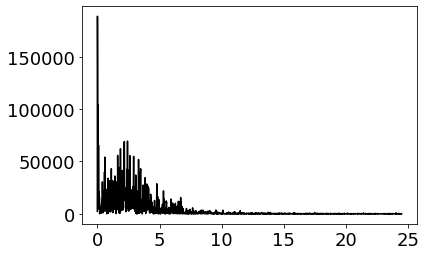

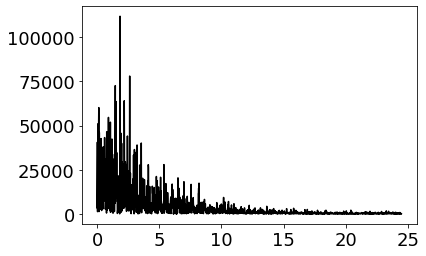

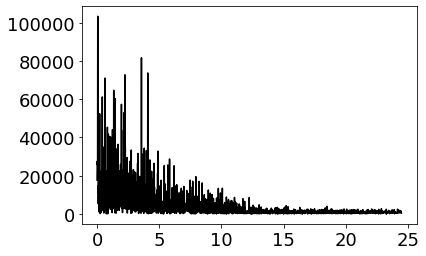

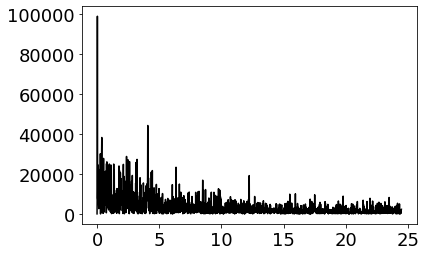

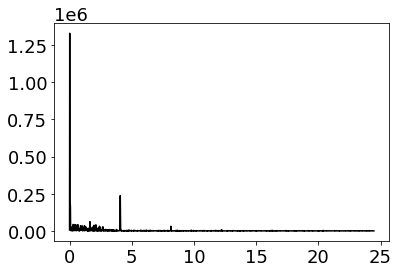

In [139]:
for i in range(5):
  plt.plot(frequency, pspec_df.values[:,i], c='k')
  plt.show()

In [37]:
'''
### Remove first values from PS:
pspec_df = pspec_df.drop([0,1,2,3,4])
pspec_df.head()
'''

'\n### Remove first values from PS:\npspec_df = pspec_df.drop([0,1,2,3,4])\npspec_df.head()\n'

In [38]:
pspec_df.shape

(1735, 1000)

In [90]:
x = pspec_df.values
x = scale(x, axis=0)

In [91]:
pca = PCA()

pca.fit(x)

X = pca.transform(x)

pca_df = pd.DataFrame(data = X)
print(pca_df.shape)
pca_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,-0.976851,5.335109,-0.635924,0.426727,-0.149198,0.594171,1.446605,0.675921,0.419251,-0.170973,0.489478,0.019826,0.845712,-0.025173,1.229741,-0.702027,0.509350,4.456346,1.394070,-0.128602,0.899398,0.099460,0.881552,1.736740,0.360861,0.605632,1.615365,0.967534,-0.895324,-1.186730,-1.241402,0.579152,-0.966251,0.297330,-0.231618,0.399253,0.883389,-0.007520,0.086558,-0.496454,...,-8.633295e-05,-3.306221e-05,-1.027651e-04,7.164829e-05,-2.508115e-04,-1.274743e-04,2.011344e-05,5.186703e-05,7.607517e-07,3.449881e-06,9.557003e-06,3.940404e-05,9.500646e-05,-4.145949e-05,5.453783e-05,-2.428012e-06,9.162121e-05,-3.606251e-05,-3.788499e-05,1.399855e-04,2.569408e-05,3.098328e-05,-4.271006e-06,5.515134e-05,2.593796e-05,1.723012e-04,3.954402e-06,-4.239946e-06,6.235083e-05,1.473911e-04,9.705129e-05,-1.991950e-05,1.209915e-05,1.607438e-05,-1.457954e-05,-5.352218e-06,-2.024611e-05,-1.570068e-05,-1.613461e-06,-2.141829e-07
1,204.148185,295.006662,-6.975532,40.328249,32.018923,-11.744238,-18.781720,-3.156247,-2.028993,1.815808,-1.930969,1.630419,-1.484843,0.421049,-2.358499,2.737002,-0.789714,-12.737896,-2.917544,1.769271,-3.908805,-0.966570,-0.770100,-3.142863,1.000340,-0.047711,-2.326815,-0.252189,0.133086,1.499012,0.488023,-1.434580,1.667625,-1.806185,0.271647,-1.649757,-0.974006,-0.932304,0.161687,-0.103077,...,5.068940e-08,3.503007e-08,-1.034998e-07,-5.273934e-08,2.472118e-08,6.801111e-09,6.192013e-08,1.629354e-08,7.994749e-08,8.467880e-08,4.711832e-08,-6.123836e-08,1.190618e-07,-5.839108e-08,-5.683294e-08,-9.653291e-08,-4.481275e-08,8.687193e-08,4.281000e-08,-8.837284e-08,1.696485e-08,8.167234e-08,-7.145102e-09,-4.399348e-08,-5.085166e-09,-3.091639e-08,5.701790e-10,2.133623e-08,-3.207290e-08,-8.294473e-08,-7.305527e-08,1.089953e-08,-7.434681e-09,-1.106567e-08,2.230697e-08,5.975942e-09,2.087342e-08,1.388444e-08,2.734884e-09,-6.735889e-10
2,372.084336,-27.892496,241.148784,-66.463167,-26.688698,-5.604747,-7.383737,1.605789,-2.771667,-1.688595,-1.477271,-0.196043,-1.757387,0.043508,-0.884610,0.808677,-0.760968,0.569646,-0.999200,0.761920,0.636406,0.916087,-1.717314,0.153342,-1.219451,0.112188,-0.313849,0.187303,-0.597867,0.987147,0.764877,-0.368211,0.717962,-0.594648,0.547503,-0.704478,0.667457,-0.467900,-0.904811,-0.205926,...,-3.637574e-08,-3.050873e-08,2.922564e-07,3.100499e-07,5.304582e-08,1.268890e-07,6.820309e-08,-2.104927e-07,-1.319437e-08,6.733425e-08,3.050249e-08,1.522877e-07,-2.541254e-07,2.254687e-07,-8.097117e-08,1.027922e-07,1.686811e-07,-6.944150e-08,6.753835e-08,1.618742e-07,-1.445596e-07,-1.500680e-08,-1.763894e-08,-6.642797e-08,2.059282e-07,-2.382255e-07,-4.784258e-08,6.591290e-08,-1.709230e-08,-2.108607e-08,3.325795e-08,-3.521617e-08,6.196569e-08,-4.798948e-08,1.852050e-08,-2.399048e-08,-1.306439e-08,-1.052073e-08,-1.940447e-08,2.089708e-08
3,267.782555,-62.642841,-25.544949,204.578245,-105.998911,-2.221424,-18.307529,2.020841,-3.571498,1.620010,-0.244569,-1.777545,-0.841440,0.693821,-0.036713,0.802497,0.965747,-2.603827,-0.956463,0.345151,-1.479030,0.942936,-1.468743,-0.078501,-0.561107,0.456978,-0.519926,-0.612897,0.008332,-0.976370,-0.592196,-0.343997,-1.069822,0.414242,-1.039104,-0.111979,0.029879,-0.511181,-0.346648,-0.089471,...,-1.987596e-07,-3.688879e-07,-2.827400e-07,-3.646514e-07,1.075803e-07,-2.435946e-07,-3.998125e-07,-8.305422e-08,1.253341e-07,-6.538196e-07,-6.942112e-08,-1.544667e-07,2.608349e-07,1.568146e-07,-8.287001e-08,-4.465702e-08,-2.497056e-07,8.481776e-08,2.654555e-07,5.884127e-08,5.118542e-07,1.672667e-07,1.152073e-07,-2.710796e-07,-1.651153e-07,-9.136843e-09,4.643394e-08,1.128100e-07,-2.096698e-07,-8.928886e-08,-8.086415e-08,-9.126744e-08,3.000561e-08,6.304849e-08,-1.127477e-08,-1.099858e-10,-2.337176e-08,-2.024111e-08,2.418073e-08,

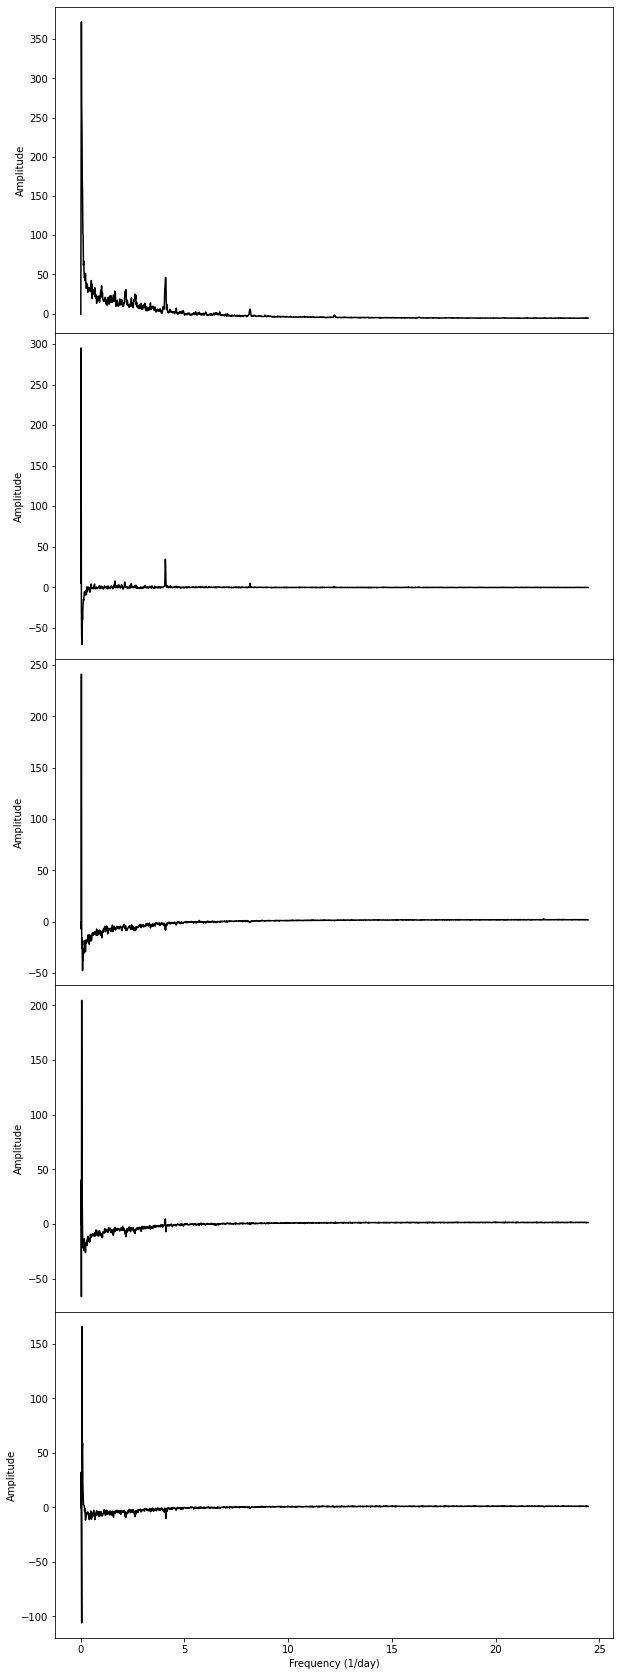

In [120]:
fig, axes = plt.subplots(5, figsize=(10,30), sharex=True)
p = 0
for i in range(5):
  axes[p].plot(frequency,pca_df[i], c='k')
  axes[p].set_ylabel('Amplitude')
  p += 1
plt.xlabel('Frequency (1/day)')
plt.subplots_adjust(hspace=0)
plt.savefig('pspcs.png', dpi=100, bbox_inches='tight')

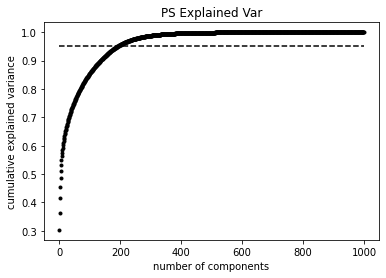

In [93]:
a = np.arange(0,len(x[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(x[0]),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('PS Explained Var')
plt.savefig('expvar.png', bbox_inches='tight')

## Method 1: Removing First 2 Components entirely

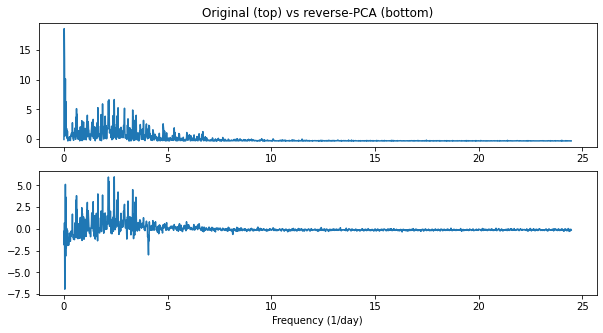

In [43]:
nComp = 200
Xhat = np.dot(pca.transform(x)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency, Xhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca_compare.png', dpi=100, bbox_inches='tight')

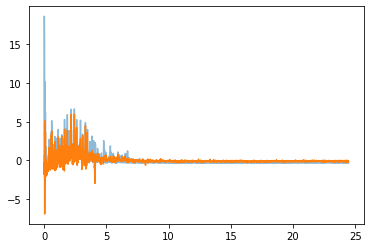

In [44]:
plt.plot(frequency,x[:,0], alpha=0.5)
plt.plot(frequency, Xhat[:,0]);

## Method 2: Bandpass Filtering First 2 Components

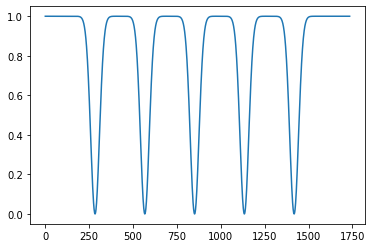

In [45]:
hrms = np.array([2,3,4,5]) * 4

filt = invgaussian(4,0.5,frequency)

for hrm in hrms:
  filt *= invgaussian(hrm,0.5,frequency)

plt.plot(filt)

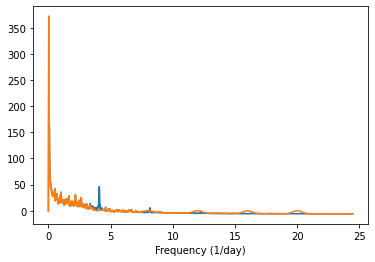

In [46]:
pca_filtered1 = pca_df[0]*filt
plt.plot(frequency,pca_df[0])
plt.plot(frequency,pca_filtered1)
plt.xlabel('Frequency (1/day)');

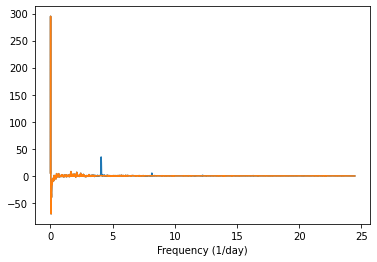

In [47]:
pca_filtered2 = pca_df[1]*filt
plt.plot(frequency,pca_df[1])
plt.plot(frequency,pca_filtered2)
plt.xlabel('Frequency (1/day)');

In [48]:
t = np.array([pca_filtered1,pca_filtered2])
filtered_transform = pca.transform(x).copy()
print(t.T.shape, filtered_transform[:,0:2].shape)
filtered_transform[:,0:2] = t.T

(1735, 2) (1735, 2)


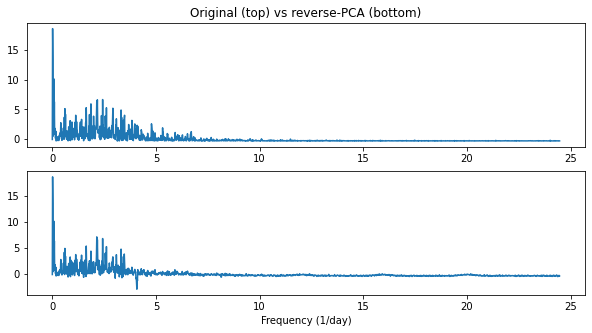

In [49]:
Xhat1 = np.dot(filtered_transform[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,x[:,0])
axes[1].plot(frequency,Xhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)');

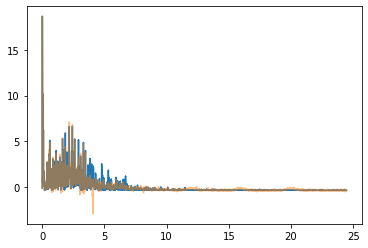

In [50]:
plt.plot(frequency,x[:,0])
plt.plot(frequency, Xhat1[:,0], alpha=0.5)

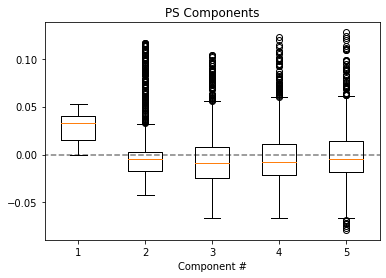

In [102]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.hlines(0, 0, 7, linestyle='--', alpha=0.5)
plt.xlabel('Component #')
plt.title('PS Components')
plt.xlim(0.5,5.5)
plt.savefig('box.png', dpi=100, bbox_inches='tight')
plt.show()

# PCA with DFTs

In [52]:
dft_dict = {}


for j, dft in enumerate(dfts):
  dft_dict["dft{0}".format(j)] = dft

dft_df = pd.DataFrame(data=dft_dict)

In [53]:
y = dft_df.values
y.real = scale(y.real, axis=0)
y.imag = scale(y.imag, axis=0)

In [54]:
print(y[:,0].real.mean(), y[:,0].imag.mean())

2.047673590086744e-18 8.190694360346977e-18


In [55]:
print(y[:,0].real.std(), y[:,0].imag.std())

1.0 1.0


In [56]:
pca.fit(y.real)

Y = pca.transform(y.real)

pca2_df = pd.DataFrame(data = Y)
print(pca2_df.shape)
pca2_df.head()

(1735, 1000)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,-1.838565,2.285646,17.770349,7.106233,7.368178,-10.637668,-2.626060,-2.243572,-13.846381,10.848089,1.315228,-0.969646,-4.073646,2.850896,5.488577,3.089539,2.677268,1.699955,2.723134,-0.758991,-7.448331,0.684649,4.619498,1.998696,-2.221349,1.014998,-3.305636,-3.341825,-1.281029,-2.799936,0.434698,1.444657,-4.433268,-0.348009,0.233129,0.427897,1.744933,-1.698010,-0.399343,0.021250,...,0.077979,0.011271,0.077716,0.067639,-0.059798,-0.134233,-0.016645,-0.045650,-0.010701,0.035649,0.099002,0.041570,0.036870,-0.016412,0.051885,0.079543,-0.010387,-0.027285,0.003300,-0.032676,0.028191,0.017208,0.080991,-0.034765,0.074579,0.033398,0.019480,0.089315,-0.047063,-0.015178,3.665082e-02,0.026613,0.056668,-0.004807,-0.012413,-0.025359,-0.045385,0.008117,0.003833,0.028619
1,18.577521,29.401864,143.302229,20.052352,31.617942,26.081528,-16.774692,-4.773384,38.976983,-45.345747,15.639597,21.872197,14.091974,36.459717,-32.558994,-30.164096,-0.782260,-16.790426,-9.483739,-3.909996,-20.563930,-16.760561,27.727537,9.105270,-13.539751,-1.569979,-2.194018,-18.203354,13.775753,0.736119,12.037921,10.580112,-2.980041,-3.960164,-5.191727,10.146385,-1.618297,-12.573240,-0.172916,-0.610997,...,0.006482,0.000957,0.002073,0.003310,0.000827,0.005151,-0.001597,0.002182,0.003555,-0.006180,-0.003062,0.000412,0.004037,-0.001740,0.003561,0.000049,0.000935,-0.001299,0.001537,0.001611,-0.002362,0.002224,-0.000668,0.001287,-0.001314,0.000703,0.003529,0.000011,-0.000321,-0.000566,4.750012e-05,0.000192,-0.000582,-0.000193,0.000861,0.000640,-0.001154,0.000289,-0.000127,-0.000984
2,175.629309,36.813442,12.354204,-88.785564,-15.707373,-37.154931,51.012836,-23.853110,62.522721,4.631871,-5.794060,58.715373,-28.826088,-3.695397,7.477388,9.436590,2.886468,3.334990,15.381342,-1.115152,1.534434,-0.513820,-14.579554,-7.670554,0.470828,5.649104,-0.530369,-2.993388,-10.227200,-3.321380,-0.464888,0.326974,-1.248534,0.225605,-0.606250,0.325711,-0.258504,-0.179586,0.497019,-0.606487,...,0.003838,0.002705,0.002906,0.003760,-0.005844,-0.003994,0.002695,-0.003042,-0.001836,-0.000193,0.002841,0.003487,0.001808,-0.001747,0.004223,0.001653,-0.001709,-0.002138,0.002357,0.002442,-0.001699,0.000876,0.000158,-0.001029,0.001793,0.000717,-0.000070,0.002739,-0.000740,-0.000685,-1.135453e-04,0.000581,-0.000772,0.000636,0.000594,0.000290,-0.000981,-0.000113,0.001074,0.000230
3,52.153110,-16.656579,9.996336,163.211009,15.689811,46.077616,108.011457,2.973764,-1.259390,-8.589616,-30.936004,2.942781,-3.972216,-9.414259,7.877772,16.711484,2.266741,8.098264,-2.084995,-12.918576,3.757250,-13.797706,-1.854545,-11.026457,1.547071,0.408415,3.017272,-5.132654,-2.218584,1.810699,-5.816985,-2.099400,-1.872624,0.269975,3.882648,4.285183,-0.489612,-2.485329,2.039062,-1.928877,...,0.000393,0.001007,0.000837,-0.001763,0.007848,0.006148,-0.002307,-0.003075,0.005904,-0.004473,-0.000070,0.003344,0.004109,-0.008059,0.000920,0.003454,-0.000885,-0.002560,0.000616,-0.002481,0.001760,-0.000166,0.001311,0.000596,-0.002121,-0.002293,0.004056,-0.001018,-0.000461,0.000955,6.657923e-04,-0.001742,0.001075,-0.000168,0.002913,-0.002163,0.000483,0.000001,-0.001501,0.000898
4,59.415372,54.288482,21.757535,56.411003,-17.068195,-9.492869,-43.337563,56.584369,78.417990,66.569370,50.875604,-51.616102,8.132829,-11.380774,-11.121566,37.458887,3.908974,3.589850,-5.084801,-1.402471,7.892929,-1.671801,2.770281,-1.256099,3.933067,6.633203,-0.260641,-0.678695,2.366151,-0.476468,-1.195845,-4.282647,0.163017,-2.004342,0.705076,4.658076,0.241850,-4.060250,1.404968,0.492474,...,-0.002352,-0.005877,0.005367,0.004747,0.001212,0.002901,-0.006677,-0.002499,0.000313,-0.000561,0.004858,-0.001949,-0.003424,-0.003007,-0.001484,-0.000744,0.000237,0.000097,0.002063,0.000635,0.001908,0.00

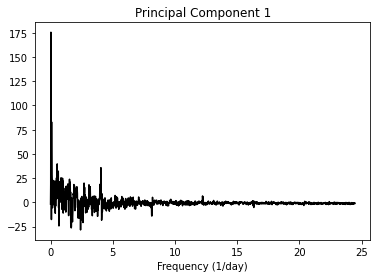

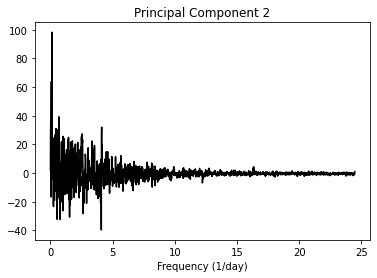

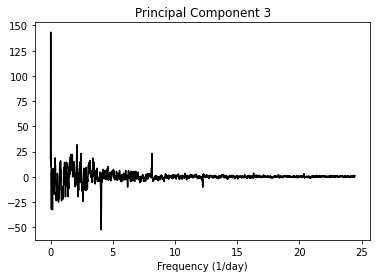

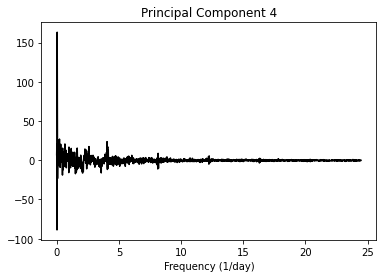

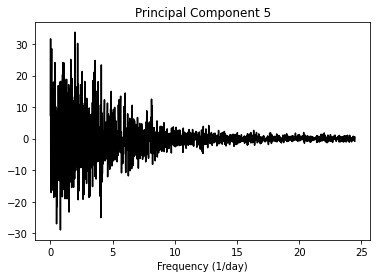

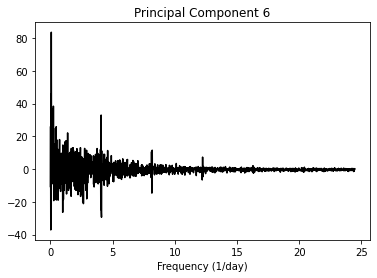

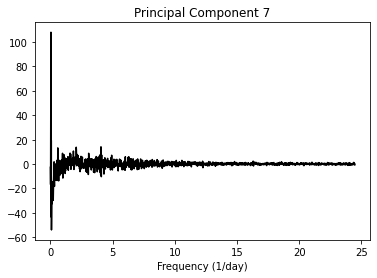

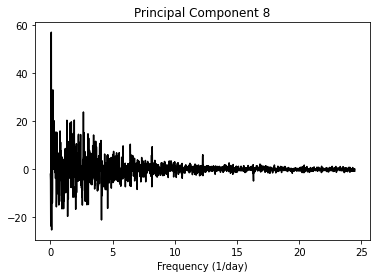

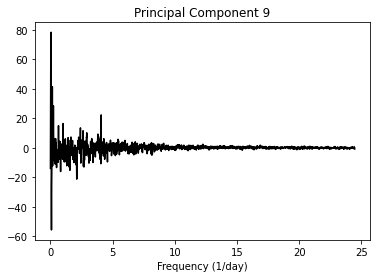

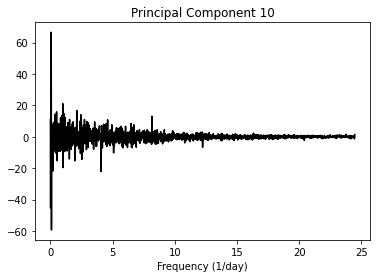

In [57]:
for i in range(0,10):
  plt.plot(frequency,pca2_df[i], 'k')
  plt.title('Principal Component {}'.format(i+1))
  plt.xlabel('Frequency (1/day)')
  plt.show()

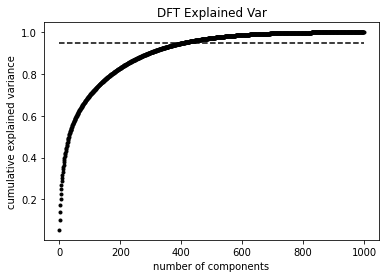

In [58]:
a = np.arange(len(y[0]))
plt.scatter(a, np.cumsum(pca.explained_variance_ratio_), c='k', marker='.')
plt.plot(a, np.full(len(a),0.95),'k--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('DFT Explained Var')
plt.savefig('expvar2.png', bbox_inches='tight')

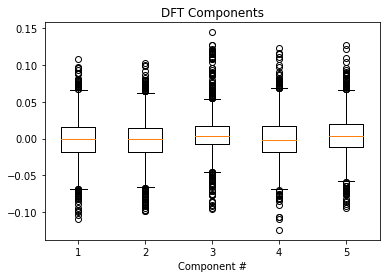

In [59]:
# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot([pca.components_[0], pca.components_[1], pca.components_[2], pca.components_[3],pca.components_[4]])
plt.xlabel('Component #')
plt.title('DFT Components')
plt.savefig('box2.png', dpi=100, bbox_inches='tight')
plt.show()

## Removing 1st Component

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


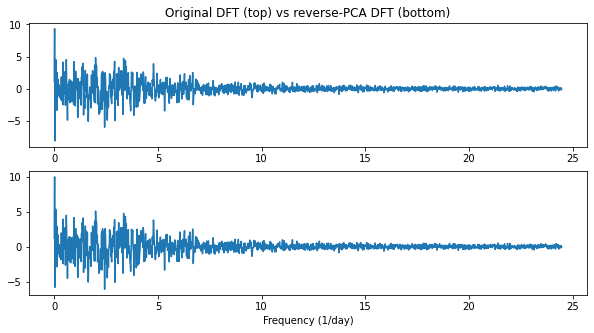

In [60]:
nComp = 1003
Yhat = np.dot(pca.transform(y.real)[:,2:nComp], pca.components_[2:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat[:,0])
#axes[0].set_ylim(-4,6)
#axes[1].set_ylim(-4,6)


axes[0].set_title('Original DFT (top) vs reverse-PCA DFT (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('pca2_compare.png', dpi=100, bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


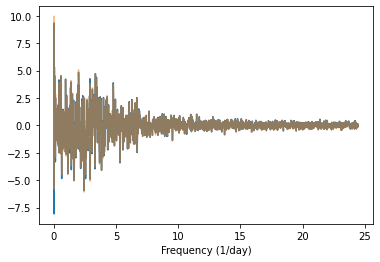

In [61]:
plt.plot(frequency,y[:,0])
plt.plot(frequency, Yhat[:,0],alpha=0.5)
plt.xlabel('Frequency (1/day)');

In [62]:
Yhatc = Yhat + (1j)*y.imag

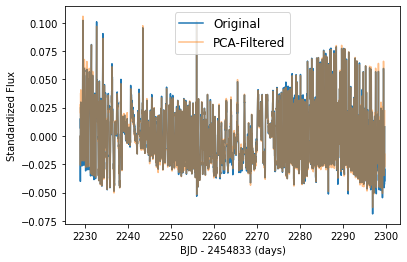

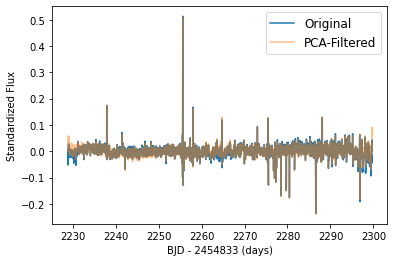

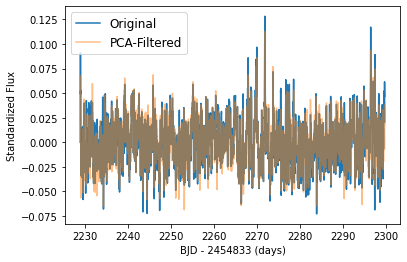

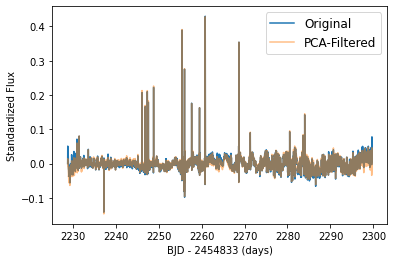

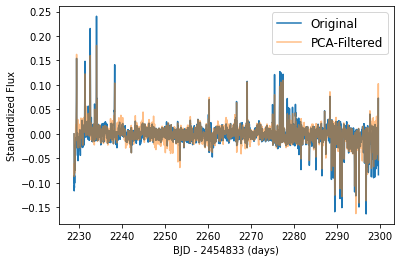

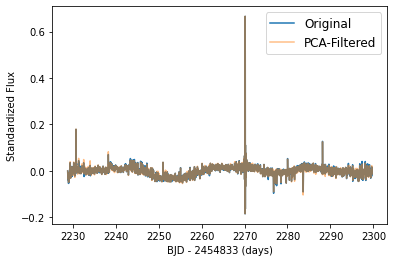

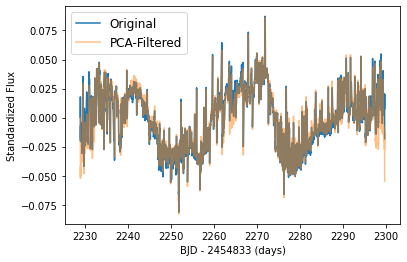

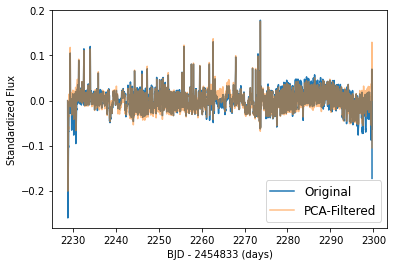

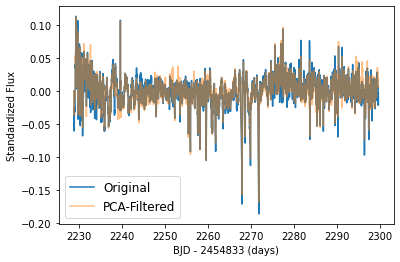

In [63]:
for i in range(0,900,100):
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhatc[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()

## Bandpass Filtering 1st Component

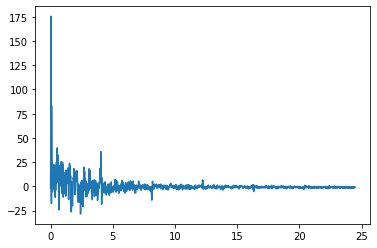

In [64]:
plt.plot(frequency, pca2_df[0])

In [65]:
np.where(pca2_df[0][250:350] == pca2_df[0][250:350].max())[0]

array([37])

In [66]:
pca2_df[0][286:289]

286    12.112054
287    35.755940
288    11.264671
Name: 0, dtype: float64

In [67]:
dft_pc1 = pca2_df[0].copy()

dft_pc1_filt = pca2_df[0].copy()

dft_pc1_gfilt = pca2_df[0] * filt

dft_pc1_filt[287] = np.mean([dft_pc1_filt[286],dft_pc1_filt[288]])

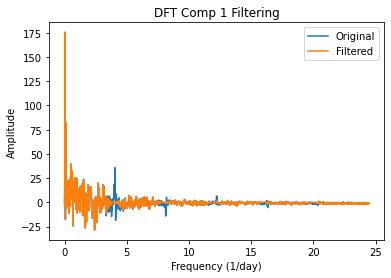

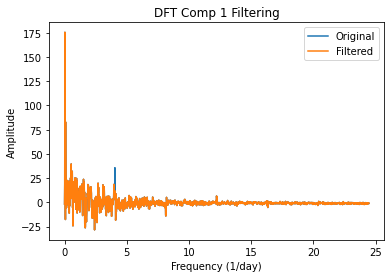

In [68]:
pca2_filtered = pca2_df[0]*filt
plt.plot(frequency,dft_pc1, label='Original')
plt.plot(frequency,pca2_filtered, label='Filtered')
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/day)')
plt.title('DFT Comp 1 Filtering')
plt.show()
plt.plot(frequency,dft_pc1, label='Original')
plt.plot(frequency,dft_pc1_filt, label='Filtered')
#plt.xlim(3.5,5)
plt.legend()
plt.ylabel('Amplitude')
plt.xlabel('Frequency (1/day)')
plt.title('DFT Comp 1 Filtering')
plt.savefig('dftfiltered.png', dpi=100, bbox_inches='tight')

In [69]:
t = np.array([pca2_filtered])
filtered_transform2 = pca.transform(y.real).copy()
print(t.T.shape, filtered_transform2[:,0:1].shape)
filtered_transform2[:,0:1] = t.T

(1735, 1) (1735, 1)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


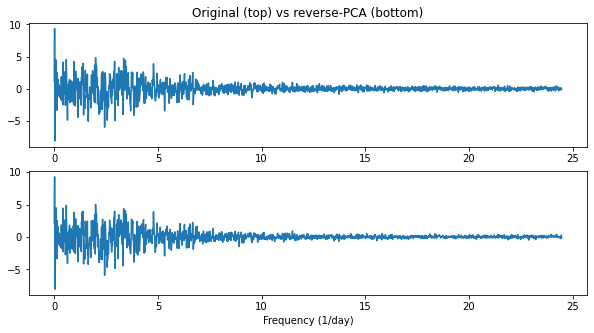

In [70]:
nComp=200

Yhat1 = np.dot(filtered_transform2[:,0:nComp], pca.components_[0:nComp,:])

fig, axes = plt.subplots(2,1,figsize = (10,5))
axes[0].plot(frequency,y[:,0])
axes[1].plot(frequency, Yhat1[:,0])
#axes[0].set_ylim(-5,7)
#axes[1].set_ylim(-5,7)


axes[0].set_title('Original (top) vs reverse-PCA (bottom)')
plt.xlabel('Frequency (1/day)')
plt.savefig('dftcompare.png', dpi=100, bbox_inches='tight')

In [71]:
Yhat1c = Yhat1 + (1j)*y.imag

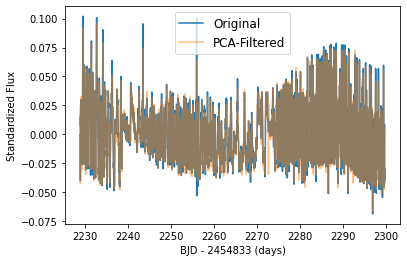

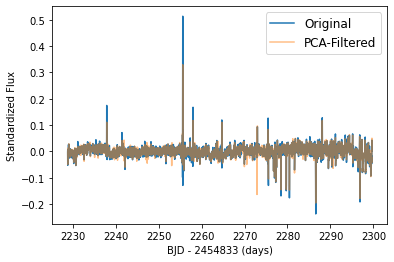

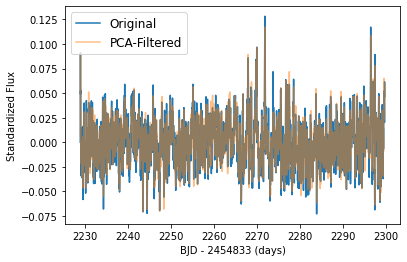

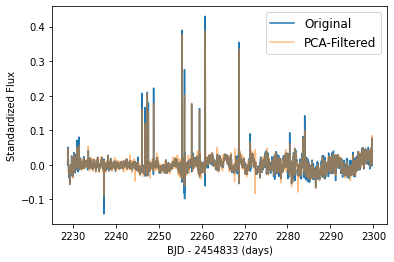

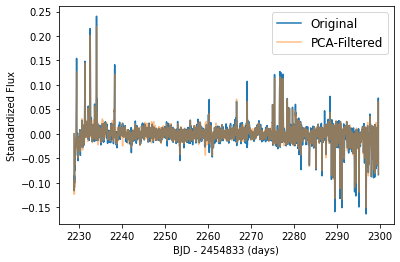

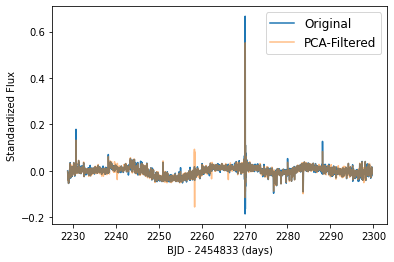

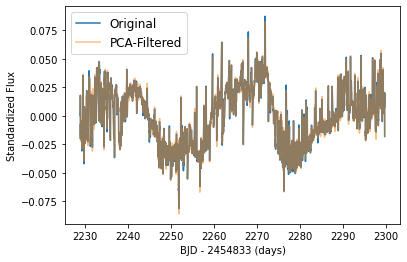

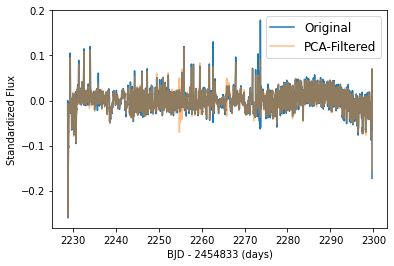

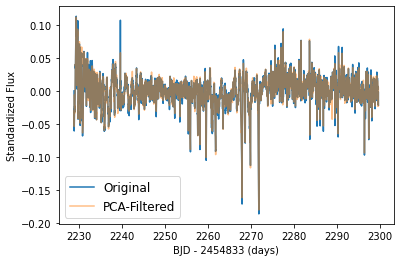

In [72]:
for i in range(0,900,100):
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhat1c[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.legend(fontsize=12)
  plt.show()

# Investigating TOIs

In [73]:
ids = [211046195, 210327027, 211110493]
j=0
for i in [1000,1001,1002]:
  plt.plot(bjds[i][1:],np.fft.irfft(y[:,i]), label='Original')
  plt.plot(bjds[i][1:],np.fft.irfft(Yhat1c[:,i]), alpha=0.5, label='PCA-Filtered')
  plt.xlabel('BJD - 2454833 (days)')
  plt.ylabel('Standardized Flux')
  plt.title('EPIC ' + str(ids[j]))
  j += 1
  plt.legend(fontsize=12)
  plt.savefig('toi{}.png'.format(j), dpi=100, bbox_inches='tight')
  plt.show()

IndexError: ignored

In [ ]:
plt.plot(bjds[1000][1:],np.fft.irfft(y[:,1000]), label='Original')
plt.plot(bjds[1000][1:],np.fft.irfft(Yhat1c[:,1000]), alpha=0.5, label='PCA-Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux')
plt.xlim(2253,2255)
plt.ylim(-0.2,0.2)
plt.legend(fontsize=12)
plt.savefig('ringing.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(bjds[1002][1:],np.fft.irfft(y[:,1002]), label='Original')
plt.plot(bjds[1002][1:],np.fft.irfft(Yhat1c[:,1002]), alpha=0.5, label='PCA-Filtered')
plt.xlabel('BJD - 2454833 (days)')
plt.ylabel('Standardized Flux')
plt.xlim(2260,2265)
plt.ylim(-0.2,0.2)
plt.legend(fontsize=12)
plt.savefig('ringing.png', dpi=100, bbox_inches='tight')
plt.show()

## Check periodicity

In [ ]:
from PyAstronomy.pyasl import foldAt

period = 0.2185
dur = np.nanmax(bjds[1000]) - np.nanmin(bjds[1000])

# Obtain the phases with respect to some
# reference point 
phases = foldAt(bjds[1000][1:], period, T0=np.nanmin(bjds[1000]))

# Sort with respect to phase
# First, get the order of indices ...
sortIndi = np.argsort(phases)
# ... and, second, rearrange the arrays.
phases = phases[sortIndi]
# Plot the result

validphase = np.where(~np.isnan(phases) == True)[0]

a, b, c = np.polyfit(phases[validphase], 
                     np.fft.irfft(y[:,1000])[sortIndi][validphase], deg=2)

p = phases[validphase]

quadfit = a*p**2 + b*p + c

plt.plot(phases-0.5, np.fft.irfft(y[:,1000])[sortIndi], 'k.')
plt.plot(phases+0.5, np.fft.irfft(y[:,1000])[sortIndi], 'k.')
#plt.plot(p-0.5, quadfit, c='cyan')
#plt.plot(p+0.5, quadfit, c='cyan')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (Raw)')
plt.xlim(-0.5,1.5)
plt.ylim(-0.1,0.1)
plt.savefig('phasefold1.png',dpi=100,bbox_inches='tight')
plt.show()

plt.plot(phases-0.5, np.fft.irfft(Yhat1c[:,1000])[sortIndi], 'k.')
plt.plot(phases+0.5, np.fft.irfft(Yhat1c[:,1000])[sortIndi], 'k.')
plt.xlabel('Phase')
plt.ylabel('Standardized Flux')
plt.title('Phase-Folded (PCA-Filtered)')
plt.xlim(-0.5,1.5)
plt.ylim(-0.1,0.1)
plt.savefig('phasefold2.png',dpi=100,bbox_inches='tight')
plt.show()

## Model flares

In [ ]:
flares = [2253.65107,
          2240.04075,
          2281.57290,
          2284.68258,
          2287.91009,
          2268.87127,
          2295.39965,
          2299.37770,
          2291.45770,
          2248.59421,
          2261.51045,
          2269.02792,
          2249.17243,
          2276.02709,
          2229.08574,
          2293.30131,
          2295.02575,
          2258.54786,
          2284.92844,
          2238.85706,
          2251.42265,
          2249.41148,
         ]

In [ ]:
fig, axes = plt.subplots(22, figsize=(10,60))

for i,flare in enumerate(flares):
  axes[i].scatter(time1, Filtered_signal1, color='k', marker='.', s=5)
  axes[i].vlines(flare, -50, 50, color='k', ls='--', alpha=0.25, label=str(flare))
  #axes[i].vlines(flare+(1./72), -50, 50, color='k', ls='--', alpha=0.75)
  #axes[i].vlines(flare-(1./96), -50, 50, color='k', ls='--', alpha=0.75)
  axes[i].set_xlim(flare-0.1,flare+0.1)
  axes[i].set_ylim(0.9,1.5)
  axes[i].set_ylabel('Rel. Flux')
  axes[i].legend()
plt.xlabel('BJD', fontsize=12)
plt.savefig('flares.png', bbox_inches='tight')
plt.show()

## Gabor Filtering

In [ ]:
from skimage.filters import gabor

In [ ]:
def gabor1D(Lambda, theta=0, bandwidth=1, sigma=None,
                 nstds=3, offset=0):

  xmax = np.max(abs(nstds * sigma * np.cos(theta)))
  xmax = np.ceil(max(1, xmax))
  xmin = -xmax
  
  x = np.arange(xmin, xmax + 1)

  gb = np.exp(-.5 * (x ** 2 / sigma ** 2)) * np.cos(2 * np.pi / Lambda * x + offset)

  return gb

In [ ]:
i=1
while i <= 32:
  print('Lambda = {}'.format(i))
  plt.plot(gabor1D(i, sigma=8, nstds=10))
  plt.show()
  i *= 2

In [ ]:
plt.plot(gabor1D(2, sigma=5, nstds=5))
plt.savefig('gabor.png', dpi=100)

In [ ]:
plt.plot(np.fft.irfft(y[:,1002]))
plt.xlim(1600,1650)

In [ ]:
conv = np.convolve(np.fft.irfft(y[:,1002]), gabor1D(2,sigma=5,nstds=5))

In [ ]:
plt.plot(conv)

In [ ]:
np.where(conv == conv.max())

In [ ]:
sigma = 4

x = np.arange(100)
ytest = np.ones(len(x))
ytest *= np.exp(-(x-30) ** 2 / sigma ** 2)

yfilt = invgaussian(50, 4, x)

In [ ]:
plt.plot(x,ytest, label='Signal')
plt.plot(x, (yfilt-1), label='Filter')
plt.title('Convolution Inputs')
plt.legend();

In [ ]:
testconv = np.convolve(ytest, yfilt-1)
plt.plot(testconv)
plt.title('Convolution');